# Clustering Gijs

In [2]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
birchFragmenten_df = fragmenten_df.copy()
birchFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [12]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(birchFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [43]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [31]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import shutil


for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    


In [32]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    _, _, Zxx = stft(y, sr, nperseg=1024)
    stft_mean = np.mean(np.abs(Zxx))

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, [stft_mean], [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))


In [34]:
from sklearn.manifold import TSNE

# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

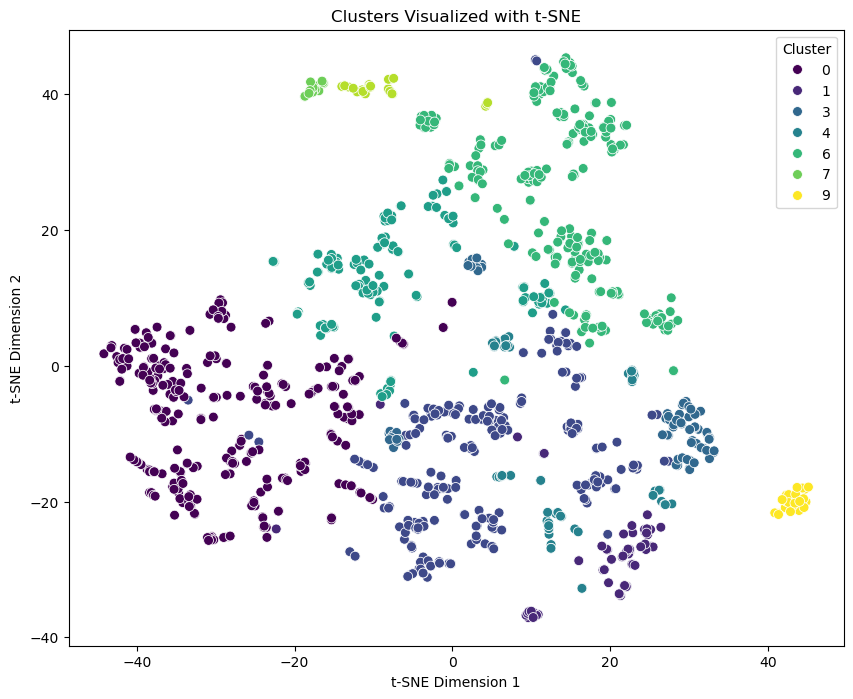

In [45]:

from sklearn.cluster import Birch

# Perform Birch clustering
birch = Birch(n_clusters=10, threshold=0.3)
cluster_labels = birch.fit_predict(features)
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title("Clusters Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc='best')
plt.show()



In [46]:
unique_clusters = np.unique(cluster_labels)
print(f"Number of clusters: {len(unique_clusters)}")

Number of clusters: 10
